In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
excel_file = "pulp_production_data.xlsx"
sheets = pd.read_excel(excel_file, sheet_name=None)

# Preview sheet names
print(sheets.keys())

dict_keys(['Plant_A', 'Plant_B'])


In [3]:
cleaned_data = []

for name, df in sheets.items():
    # Basic cleanup: drop empty rows/columns, handle column names
    df.dropna(how='all', inplace=True)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Parse date if needed
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Drop rows with missing critical data
    df.dropna(subset=['date', 'production_amount'], inplace=True)
    
    # Add a sheet name column if needed
    df['source_sheet'] = name
    
    cleaned_data.append(df)

# Combine all sheets into a single DataFrame
combined_df = pd.concat(cleaned_data, ignore_index=True)


In [4]:
# Daily production
daily_totals = combined_df.groupby('date')['production_amount'].sum().reset_index()

# Monthly production
combined_df['month'] = combined_df['date'].dt.to_period('M')
monthly_totals = combined_df.groupby('month')['production_amount'].sum().reset_index()

In [5]:
# Production by pulp type
by_pulp_type = combined_df.groupby('pulp_type')['production_amount'].sum().sort_values(ascending=False)

# Production by quality grade
by_quality = combined_df.groupby('quality_grade')['production_amount'].sum().sort_values(ascending=False)

# Cross-analysis
cross = combined_df.groupby(['pulp_type', 'quality_grade'])['production_amount'].sum().unstack().fillna(0)

C:\Users\91855\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91855\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


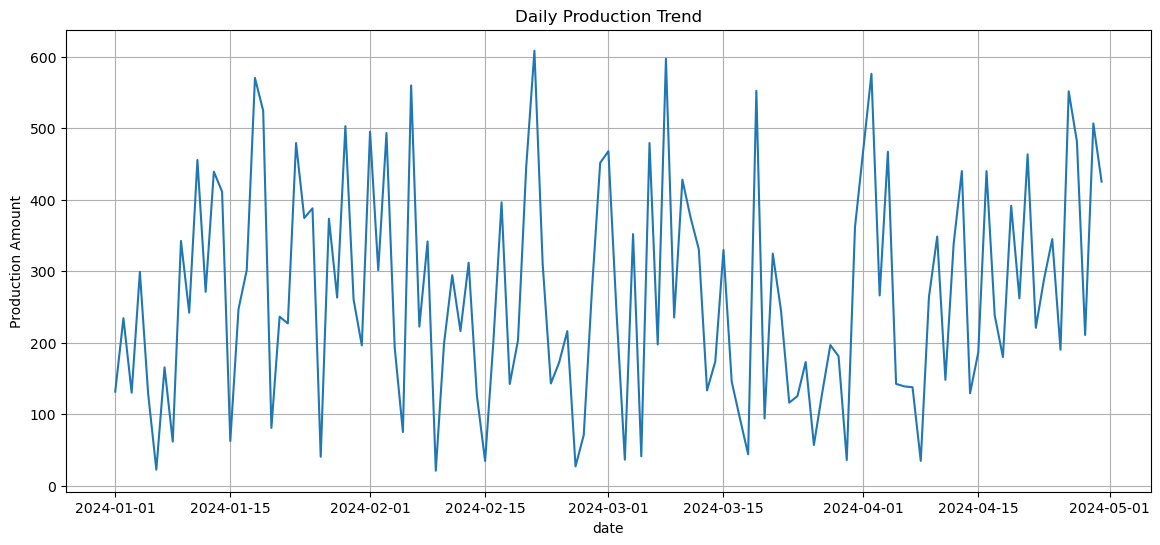

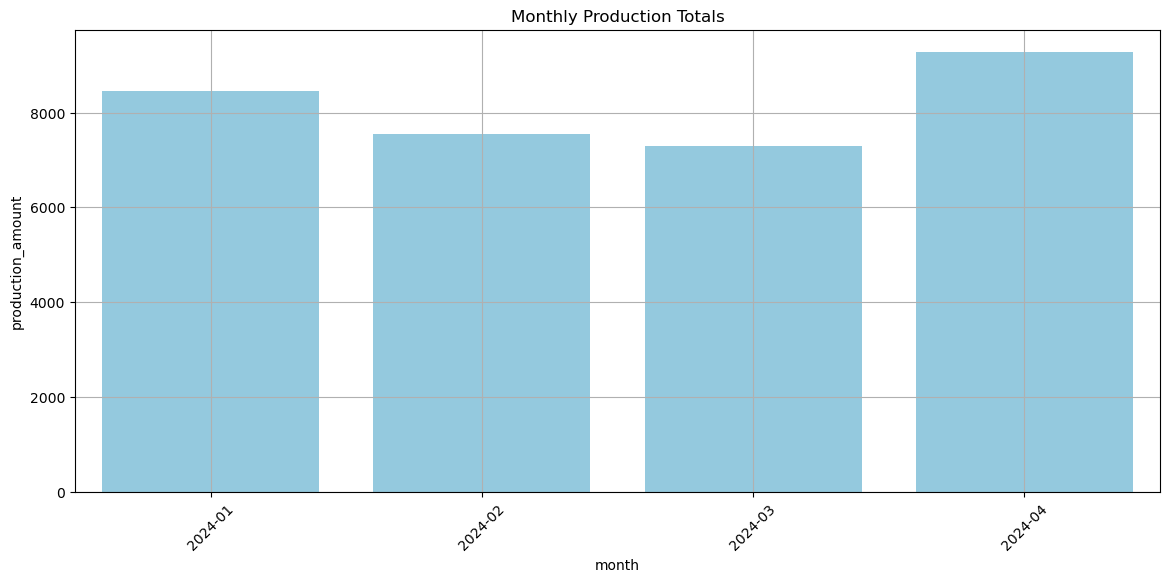

In [6]:
# Plot daily trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_totals, x='date', y='production_amount')
plt.title("Daily Production Trend")
plt.ylabel("Production Amount")
plt.grid(True)
plt.show()

# Plot monthly trend
monthly_totals['month'] = monthly_totals['month'].astype(str)
plt.figure(figsize=(14, 6))
sns.barplot(data=monthly_totals, x='month', y='production_amount', color='skyblue')
plt.title("Monthly Production Totals")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Anomalies - Z-score method
from scipy.stats import zscore
daily_totals['zscore'] = zscore(daily_totals['production_amount'])

anomalies = daily_totals[np.abs(daily_totals['zscore']) > 2]

In [7]:
summary = combined_df.describe(include='all')

print("Top 5 Pulp Types by Production:\n", by_pulp_type.head())
print("\nTop 5 Quality Grades by Production:\n", by_quality.head())
print("\nAnomalous Days in Production:\n", anomalies[['date', 'production_amount']])

Top 5 Pulp Types by Production:
 pulp_type
Kraft Hardwood    7663.55
Chemical          7046.31
Recycled          6419.95
Kraft Softwood    5785.78
Mechanical        5670.52
Name: production_amount, dtype: float64

Top 5 Quality Grades by Production:
 quality_grade
Grade B    11215.38
Grade C    10733.68
Grade A    10637.05
Name: production_amount, dtype: float64

Anomalous Days in Production:
          date  production_amount
51 2024-02-21             608.44
67 2024-03-08             597.35
